In [ ]:
!pip install tensorflow

In [ ]:
!pip install keras

In [1]:
from __future__ import print_function
from __future__ import division
from sklearn import cross_validation
import tensorflow as tf
import numpy as np
import seaborn as sns
import itertools
from scipy.stats import gaussian_kde
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers.core import Dense, Dropout, Activation
from keras import optimizers,initializers
import pandas as pd
from matplotlib import pyplot as plt
from keras.optimizers import RMSprop
from keras.utils import np_utils
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
sns.set(rc={'axes.facecolor':'white'})
pd.set_option('display.max_rows', 1000)

%matplotlib inline

/home/katya/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [2]:
def containsMutations(genotype):
    return genotype.split(':')

def makeBinary(unique_mutations, genotype):
    genotypeList = containsMutations(genotype)
    indexList = []
    
    for i in range(len(genotypeList)):
        indexList.append(unique_mutations.index(genotypeList[i]))
    
    line = np.zeros((1,len(unique_mutations)))
    line[:,indexList] = 1.
    
    return line

In [3]:
filepath = '/home/katya/start/HIS3InterspeciesEpistasis/Analysis/Katya/NN/S9_new.csv'

In [4]:
data = pd.DataFrame.from_csv(filepath, sep = '\t')
median = np.median(data.index.str.len())

clean_data = data[(data.nonsense == 0) & (data.middle == 1) & \
                                    (data.nat_lib == 1) & (data.stop == 0) & \
                                    (data.index.str.len() == median)]

data = pd.DataFrame(clean_data.mut_list_Scer)
data['fitness'] = clean_data.s
data.index = data.mut_list_Scer
data.drop(['mut_list_Scer'], axis=1, inplace=True)
data['aa_seq'] = clean_data.index
data = data.reset_index()

In [5]:
data.columns = ['mutList', 'fitness', 'aa_seq']
data.mutList = data.mutList.fillna('')
unique_mutations = set(':'.join(data.mutList).split(':'))
unique_mutations = sorted(list(unique_mutations))
if '' in unique_mutations:
    unique_mutations.remove('')

nn_genotypes_values = np.zeros((len(data), len(unique_mutations)))
nn_brightness_values = data.fitness.values
aa_seq = data.aa_seq

for i in range(len(data.mutList)):
    if data.mutList[i] != '':
        nn_genotypes_values[i] = makeBinary(unique_mutations, data.mutList[i])[0]

nn_brightness_values = (nn_brightness_values - min(nn_brightness_values)) / max(
    nn_brightness_values - min(nn_brightness_values))

In [7]:
model = Sequential()

init = initializers.Orthogonal(gain=1.0, seed=None)

model.add(Dense(1, input_dim=nn_genotypes_values.shape[1], activation='sigmoid', kernel_initializer=init))
model.add(Dense(100, activation='sigmoid', kernel_initializer=init))
model.add(Dense(1, activation='sigmoid', kernel_initializer=init))

opt = optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(optimizer=opt,
              loss='mean_squared_error',
              verbose=0)

hist = model.fit(nn_genotypes_values, nn_brightness_values, epochs=100, batch_size=400, shuffle=True, verbose=0)
weights = model.layers[0].get_weights()[0]
biases = model.layers[0].get_weights()[1]

proba = model.predict_proba(nn_genotypes_values, batch_size=100, verbose=0)

true = nn_brightness_values
predicted = proba.flatten()
fitness_potential = nn_genotypes_values.dot(weights) + biases[0]

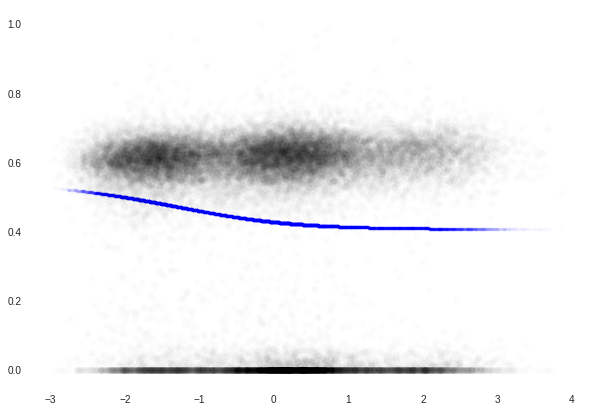

In [8]:
plt.figure(figsize = [10,7])
plt.plot(fitness_potential, true, 'ok', alpha = 0.01)
plt.plot(fitness_potential, predicted, '.b', alpha = 0.01);

In [10]:
_, _, R1, _, _ = stats.linregress(true,predicted)
print (R1)

0.136205680128


### 2. Control

In [33]:
def read_data(chunk):
    input_file = '/home/katya/start/HIS3InterspeciesEpistasis/Analysis/Katya/NN/data/' + chunk + '.txt'
    data = pd.read_table(input_file)
    data.columns = ['mutList', 'fitness', 'aa_seq']
    data.mutList = data.mutList.fillna('')
    unique_mutations = set(':'.join(data.mutList).split(':'))
    unique_mutations = sorted(list(unique_mutations))
    if '' in unique_mutations:
        unique_mutations.remove('')

#     data = data.reindex(np.random.permutation(data.index))
    nn_genotypes_values = np.zeros((len(data), len(unique_mutations)))
    nn_brightness_values = data.fitness.values
    aa_seq = data.aa_seq
    
    for i in range(len(data.mutList)):
        if data.mutList[i] != '':
            nn_genotypes_values[i] = makeBinary(unique_mutations, data.mutList[i])[0]

    nn_brightness_values = (nn_brightness_values - min(nn_brightness_values)) / max(
        nn_brightness_values - min(nn_brightness_values))
    
    return nn_genotypes_values, nn_brightness_values, unique_mutations, aa_seq

In [34]:
data, labels, unique_mutations, aa_seq = read_data('S7')
model = Sequential()

init = initializers.Orthogonal(gain=1.0, seed=None)

model.add(Dense(1, input_dim=data.shape[1], activation='sigmoid', kernel_initializer=init))
model.add(Dense(100, activation='sigmoid', kernel_initializer=init))
model.add(Dense(1, activation='sigmoid', kernel_initializer=init))

opt = optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(optimizer=opt,
              loss='mean_squared_error',
              verbose=0)

hist = model.fit(data, labels, epochs=500, batch_size=400, shuffle=True, verbose=0)
weights = model.layers[0].get_weights()[0]
biases = model.layers[0].get_weights()[1]

proba = model.predict_proba(data, batch_size=100, verbose=0)

true = labels
predicted = proba.flatten()
fitness_potential = data.dot(weights) + biases[0]

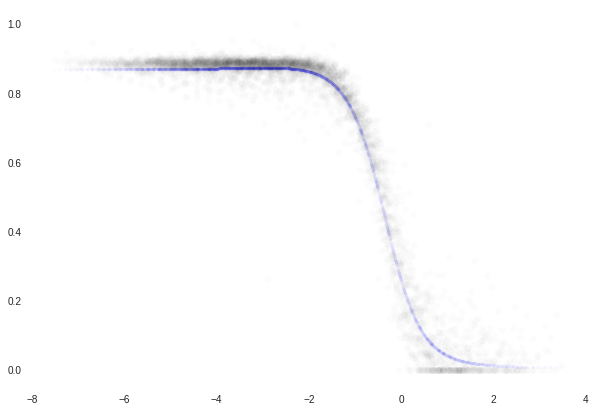

In [35]:
plt.figure(figsize = [10,7])
plt.plot(fitness_potential, true, 'ok', alpha = 0.01)
plt.plot(fitness_potential, predicted, '.b', alpha = 0.01);

In [36]:
_, _, R2, _, _ = stats.linregress(true,predicted)

In [37]:
print (R1, R2)

0.136651594167 0.987597977846
